In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Linear Regression

This notebook is inspired by a lecture and assignment on Linear Regression taken within MSc course.

Regression is used when we have noisy observations i.e. n, d - dimensional, inputs:
$\bold{x}_{1:n} = [\bold{x}_{1}, \cdots, \bold{x}_{n}]$, with corresponding outputs: 
$\bold{y}_{1:n} = [y_{1}, \cdots, y_{n}]$.

Regression is used to find the map between the inputs and the outputs.

Linear regression is the simplest approach.

The general linearised model (GLM) is given by:
$$
y(x; w) = \sum_{j=1}^{m} w_j \phi_j(x) = \mathbf{w}^T \phi(x)
$$
where $\bold{w} = (w_{1}, \cdots, w_{m})^{T}$ are the weights and 
$\bold{\phi} = (\phi_1, \cdots, \phi_m)^T$ are arbitrary basis functions. 

The GLM is linear in $\bold{w}$, the basis functions, $\bold{\phi}(\bold{x})$ can be non-linear whilst the regression model is still linear. 

Examples of basis functions include:
 - linear, 
 - polynomial,
 - radial basis functions (RBF),
 - Fourier series


## Least squares

The best values of the weights $\bold{w}$ can be found using least squares regression, (minimising a quadratic loss function):

$$
\mathbf{w}_{\text{LS}} = \left( \Phi^T \Phi \right)^{-1} \Phi^T \mathbf{y}_{1:n}
$$

Where $\Phi$ is a n*m design matrix stemming from the evaluation of each basis function $\phi_j$ on each datapoint $\bold{x}_i$.

In practise $\Phi^T \Phi$ is not explicitly calculated due to unstability of matrix inversions, instead the QR decomposition is calculated. 
This is done within libraries such as numpyp.linalg.lstsq.

Application to generated example datasets:

In [2]:
#generating example functions
a_0 = -0.3
a_1 = 0.5

def noise(size, variance):
    return np.random.normal(scale=np.sqrt(variance), size=size)

def f(X, noise_variance):
    """
    Linear function plus noise
    """
    return a_0 + a_1*X + noise(X.shape, noise_variance)


def g(X, noise_variance):
    """
    Sinus function plus noise
    """
    return 0.5 + np.sin(2*np.pi*X) + noise(X.shape, noise_variance)

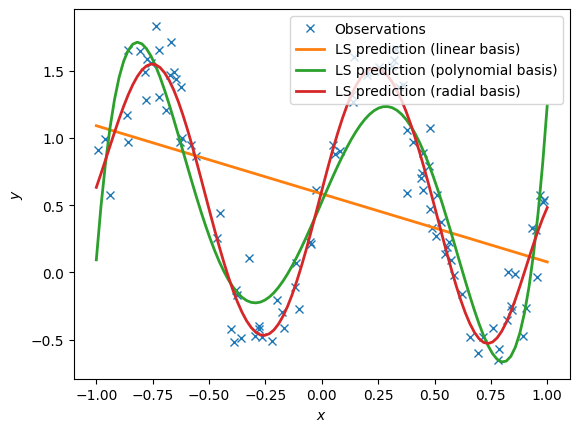

In [3]:
from linear_regression import design_matrix, LinearBasis, RadialBasisFunctions, PolynomialBasis

# generate some sample data
N_samples = 100
sigma = 0.2
X_g = np.random.uniform(-1, 1, size=N_samples)[:, None]
Y_g = g(X_g, noise_variance=sigma**2)
X, Y = X_g, Y_g # save for later

#comparisson of different basis functions
phi_linear = LinearBasis()

poly_degree = 5
phi_poly = PolynomialBasis(degree=poly_degree) #different degrees lead to different results
#equivalent to using np.polyfit() but defining own basis fucntions gives more flexibility

# varying ...
ell = 0.2 #lengthscale
num_terms = 10
Xc = np.linspace(-1, 1, num_terms) #centers

phi_radial = RadialBasisFunctions(Xc, ell)

# evaluate design matrix for each basis function
Phi_lin = design_matrix(X, phi_linear)
Phi_pol = design_matrix(X, phi_poly)
Phi_rad = design_matrix(X, phi_radial)

# carry out the least squares fit
w_LS_lin = np.linalg.lstsq(Phi_lin, Y, rcond=None)[0]
w_LS_pol = np.linalg.lstsq(Phi_pol, Y, rcond=None)[0]
w_LS_rad = np.linalg.lstsq(Phi_rad, Y, rcond=None)[0]

# use fitted model to make predictions at 100 points
X_p = np.linspace(-1, 1, 100)[:, None]

Phi_p_lin = design_matrix(X_p, phi_linear)
Y_p_lin = Phi_p_lin @ w_LS_lin

Phi_p_pol = design_matrix(X_p, phi_poly)
Y_p_pol = Phi_p_pol @ w_LS_pol

Phi_p_rad = design_matrix(X_p, phi_radial)
Y_p_rad = Phi_p_rad @ w_LS_rad

# plotting code
plt.plot(X, Y, 'x', label='Observations')
plt.plot(X_p, Y_p_lin, lw=2, label='LS prediction (linear basis)')
plt.plot(X_p, Y_p_pol, lw=2, label='LS prediction (polynomial basis)')
plt.plot(X_p, Y_p_rad, lw=2, label='LS prediction (radial basis)')
plt.xlabel('$x$'); plt.ylabel('$y$'); plt.legend(loc='best');

Can see the different performance of the different basis functions on the noisy sinusoidal data. Can change the hyperparameters to change the performance, i.e. degree of polynomial basis functions, however using extreme values can lead to overfitting with greater errors. For example, if we look at the contributions from each basis function, as shown below, we can see that larger degree polynomials lead to extreme values at large |x|, so we are relying on different degree polynomials cancelling each other out, prone to error.

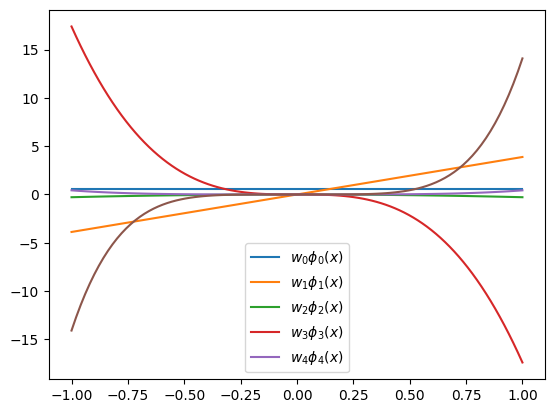

In [4]:
for i in range(phi_poly.num_basis):
    plt.plot(X_p, Phi_p_pol[:, i] * w_LS_pol[i] ,'-')
plt.legend([f'$w_{j} \phi_{j}(x)$' for j in range(poly_degree)], loc='best');

Issues with least squares: 
- How do you quantify the measurement noise?
- How many basis functions should you use?
- Which basis functions should you use?
- How do we pick the parameters of the basis functions, e.g., the lengthscale ℓ
 for the RBFs?

## Maximum Likelihood Estimation (MLE)

This probabilistic interpretation can fix some of these issues.

We model the measurement process using a likelihood function: 
$$
\mathbf{y}_{1:n} \mid \mathbf{x}_{1:n}, \mathbf{w} \sim \mathbf{P}\left(\mathbf{y}_{1:n} \mid \mathbf{x}_{1:n}, \mathbf{w}\right)
$$

this expresses how plausible the outputs are given the inputs and that we know the weights.

Assuming that the measurements are independent means that the overall probability is the product of the probabilities of a single measurement. We can also assume that the measurement is around the model prediction but with a gaussian error (likelihood can be modelled as a gaussian). Therefor the gaussian likelihood of many independant observations is 
$$
P\left(\mathbf{y}_{1:n} \mid \mathbf{x}_{1:n}, \mathbf{w}, \sigma\right) = \mathcal{N}\left(\mathbf{y}_{1:n} \mid \Phi \mathbf{w}, \sigma^2 \mathbf{I}_n\right)
$$
where $\sigma$ models the noise on the data, and $I$ is the identity.

The model can then be trained by finding the wieghts that maximise the likelihood (analytically tractable in the Gaussian case).

Can also maximise the likelihood over the noise parameter, $\sigma$, the MLE estimate can be interpreted as the standard error in the least squares prediction $\Phi w_{MLE}$ with respect to $y$, (the residuals of the fit) normalised by $\sqrt{n}$.

Predictions can then be made using laws of probability.
$$
P\left(y \mid x, \mathbf{w}_{\text{MLE}}, \sigma^2_{\text{MLE}}\right) = \mathcal{N}\left(y \, \bigg|\; \mathbf{w}_{\text{MLE}}^T \phi(x), \sigma^2_{\text{MLE}}\right)
$$


In [5]:
from linear_regression import least_squares_MLE

#example with using radial basis functions as before

w_MLE, sigma_MLE = least_squares_MLE(Phi_rad, Y, X)

Y_p = (Phi_p_rad @ w_MLE).flatten()

Y_l = Y_p - 2. * sigma_MLE # Lower predictive bound (95% confidence interval)
Y_u = Y_p + 2. * sigma_MLE # Upper predictive bound (95% confidence interval)

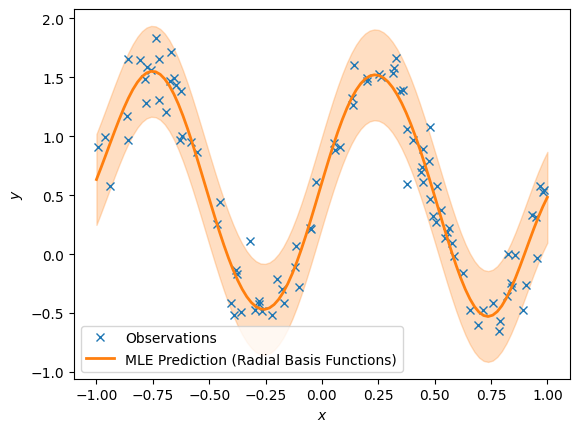

In [6]:
plt.plot(X, Y, 'x', label='Observations')
plt.plot(X_p, Y_p, lw=2, label='MLE Prediction (Radial Basis Functions)')
plt.fill_between(X_p.flatten(), Y_l, Y_u, color='C1', alpha=0.25)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend(loc='best');

Remaining Issues with Maximum Likelihood:
- How many basis functions should I use?
- Which basis functions should I use?
- How do I pick the parameters of the basis functions, e.g., the lengthscale 
ℓ of the RBFs?
- Uncertainty estimates don't account for extrapolation outside of range of data

## Bayesian Linear Regression

Same as previous we wish to model the data using fixed basis/features as well as modelling the measurement process using a likelihood function, however this method incorporates a prior to model the uncertainty in the model parameters.
For example the following gaussian prior:
$$
P\left(\mathbf{w} \mid \alpha\right) = \mathcal{N}\left(\mathbf{w} \mid \mathbf{0}, \alpha^{-1} \mathbf{I}\right) = \left(\frac{\alpha}{2\pi}\right)^{\frac{m}{2}} \exp\left\{-\frac{\alpha}{2} \mathbf{w}^\top \mathbf{w}\right\}
$$

can be interpreted as, before we see the data we expect $w$ to be around zero with a precision of $\alpha$, where precision is $\frac{1}{\sigma^{2}}$

Bayes rule is then used to combine the prior and the likelihood to get a posterior for the weights, essentially our state of knowledge about $w$ after we see the data.

For a gaussian likelihood and prior this gives: 
$$
\log P(w \mid x_{1:n}, y_{1:n}, \sigma, \alpha) = 
-\frac{\beta}{2} \|\Phi w - y_{1:n}\|^2 - \frac{\alpha}{2} w^\top w + \text{const}
$$

(this has the same form as ridge regression)

Maximising the posterior gives the maximum-a-posteriori (MAP) estimate of the weights. We dont have to chose $\alpha$ and $\beta$ they come out naturally from the prior and likelihood.

In the case of a gaussian prior and likelihood the posterior is gaussian too, if it is not the math is usually not analytic and the method would require sampling instead (MCMC). For the gaussian case the posterior can be expressed as $P(w \mid x_{1:n}, y_{1:n}, \alpha, \beta) = \mathcal{N}(w \mid m, S)$ where the covariance matrix is given by $S = \left( \beta \Phi^\top \Phi + \alpha I \right)^{-1}$, and the mean vector is $m = \beta S \Phi^\top y_{1:n}$.

So what do we know about $y$ at a new $x$ after seeing the data. Marginalising the distibution of weights leads to the derivation of the predictive uncertainty at input values $x$ is:
$s^2(x) = \phi(x)^\top S \phi(x) + \frac{1}{\beta}$, this can be seperated into two contributions, the measurement noise: $\frac{1}{\beta}$ and the epistemic uncertainty induced by limited data represented by the rest of the equation.

We can show this with an example using an increasing number of samples for a straight line (f(x)).

In [7]:
N_list = [0, 1, 5]

beta = 25.0
alpha = 2.0

X = np.random.uniform(-1, 1, size=(N_list[-1], 1))
y = f(X, noise_variance=1/beta) # Training target values

X_test = np.linspace(-1, 1, 100)[:, None]
y_true = f(X_test, noise_variance=0)

phi = LinearBasis()
Phi_test = design_matrix(X_test, phi)

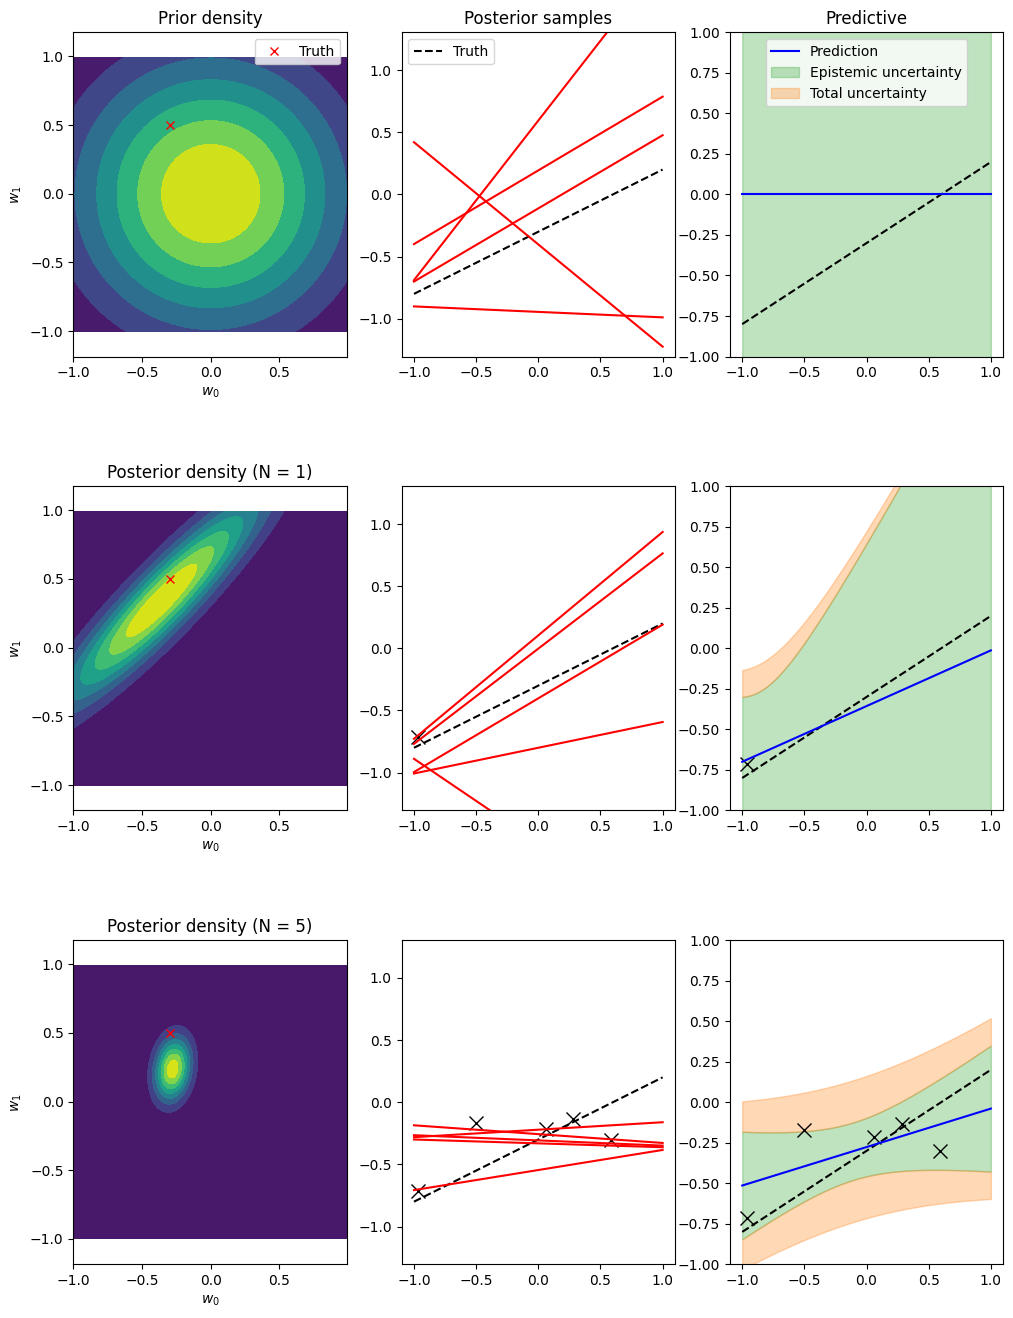

In [9]:
from bayesian_linear_regression import posterior, posterior_predictive, plot_data, plot_truth, plot_posterior_samples, plot_posterior, plot_predictive

# plotting code
plt.figure(figsize=(12, 16))
plt.subplots_adjust(hspace=0.4)
for i, N in enumerate(N_list):
    X_N = X[:N]
    y_N = y[:N]

    # Design matrix of training observations
    Phi_N = design_matrix(X_N, phi)
    
    # Mean and covariance matrix of posterior
    m_N, S_N = posterior(Phi_N, y_N, alpha, beta)
    
    # Mean, epistemitic and total variances of posterior predictive 
    y_m, y_epi, y_var = posterior_predictive(Phi_test, m_N, S_N, beta)
    
    # Draw 5 random weight samples from posterior and compute y values
    w_samples = np.random.multivariate_normal(m_N.ravel(), S_N, 5).T
    y_samples = Phi_test.dot(w_samples)
    
    plt.subplot(len(N_list), 3, i * 3 + 1)
    plot_posterior(m_N, S_N, a_0, a_1)
    if N == 0:
        plt.title('Prior density')
        plt.legend()
    else:
        plt.title(f'Posterior density (N = {N})')

    plt.subplot(len(N_list), 3, i * 3 + 2)
    plot_data(X_N, y_N)
    plot_truth(X_test, y_true)
    plot_posterior_samples(X_test, y_samples)
    plt.ylim(-1.0, 1.0)
    if N == 0:
        plt.title('Posterior samples')
        plt.legend()

    plt.subplot(len(N_list), 3, i * 3 + 3)
    plot_data(X_N, y_N)
    plot_truth(X_test, y_true, label=None)
    plot_predictive(X_test, y_m, y_epi, y_var)
    plt.ylim(-1.0, 1.0)
    if N == 0:
        plt.title('Predictive')
        plt.legend()

The prior with $N=0$ datapoints is unbiased to any particular choice of weights, hence the circular contours
Samples from the prior correspond to fitting a straight line to zero points, while samples from the posterior with 
$N=1$ correspond to fitting a line to a single point.
The posterior for each iteration becomes the prior for the next one.
The posterior distribution narrows in on the exact solution for the weights
As we add data, the epistemic uncertainty reduces, up until the point where the full uncertainty is domininated by the noise and remains constant.


An example using the noisy sine curve:

In [11]:
X, Y = X_g, Y_g # restore previous data

ell = 0.1      # lengthscale hyperparameter
M = 10         # number of basis functions
alpha = 10     # precision for weight prior
beta = 20      # precision for noise model

Xc = np.linspace(1, -1, M)
phi_rad = RadialBasisFunctions(Xc, ell)
Phi_rad = design_matrix(X, phi_rad)

mN, SN = posterior(Phi_rad, Y, alpha, beta) # reuse previous function to compute posterior

# evaluate the predictive distribution
X_p = np.linspace(-1, 1.1, 100)[:, None]
Phi_p = design_matrix(X_p, phi_rad)
Y_p, V_ep, V_p = posterior_predictive(Phi_p, mN, SN, beta)

S_p_ep = np.sqrt(V_ep)
S_p = np.sqrt(V_p)
Y_l_ep = Y_p - 2.*S_p_ep  # Lower epistemic predictive bound
Y_u_ep = Y_p + 2.*S_p_ep  # Upper epistemic predictive bound
Y_l = Y_p - 2.*S_p        # Lower predictive bound
Y_u = Y_p + 2.*S_p        # Upper predictive bound

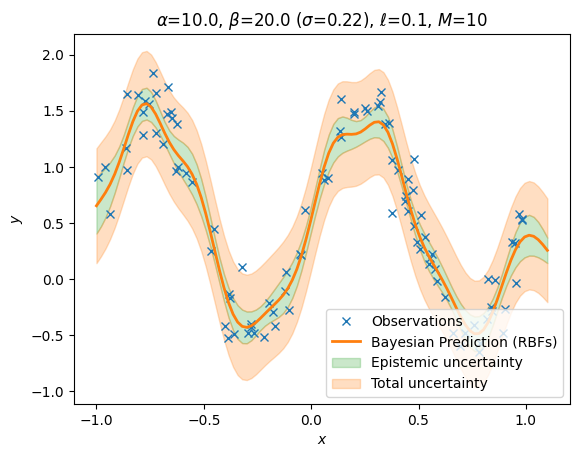

In [12]:
# plotting code
plt.plot(X, Y, 'x', label='Observations')
plt.plot(X_p, Y_p, lw=2, label='Bayesian Prediction (RBFs)')
plt.fill_between(X_p.flatten(), Y_l_ep, Y_u_ep, color='C2', alpha=0.25, label='Epistemic uncertainty')
plt.fill_between(X_p.flatten(), Y_l, Y_l_ep, color='C1', alpha=0.25, label='Total uncertainty')
plt.fill_between(X_p.flatten(), Y_u_ep, Y_u, color='C1', alpha=0.25)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend(loc='lower right')
plt.title(rf'$\alpha$={alpha:.1f}, $\beta$={beta:.1f} ($\sigma$={1/np.sqrt(beta):.2f}), $\ell$={ell}, $M$={M}');

It can be seen that the above model is overfitting to the noise on the data.


We can sample models form the posterior as with the straight line above.

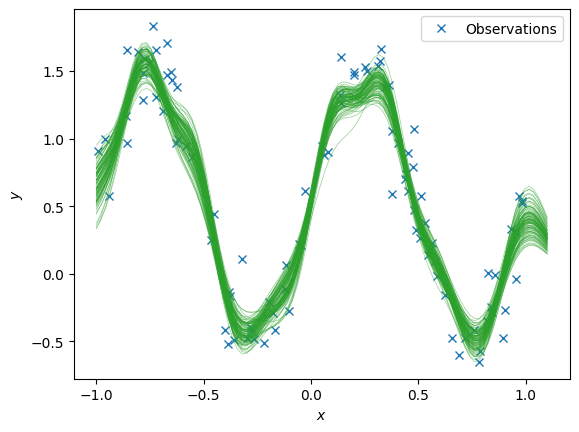

In [13]:
# plotting code
plt.plot(X, Y, 'x', label='Observations')
for i in range(100):
    w = np.random.multivariate_normal(mN.ravel(), SN) # ravel() needed to ensure mN is 1D array
    Y_p_s = np.dot(Phi_p, w)
    plt.plot(X_p, Y_p_s, color='C2', linewidth=0.5, alpha=0.5);
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend();

There are still some issues with Bayesian Linear Regression:

How many basis functions should I use?
Which basis functions should I use?
How do I pick the parameters of the basis functions, e.g., the lengthscale ℓ of the RBFs, α, etc.?

These hyperparameters can be found by using a prior distribution over the hyperparameters and then  writing the posterior over the entire thing, this can then be sampled MCMC etc or instead you can make an evidence approximation.

This can also be done using BayesianRidge function within sci-kit learn.